# MCMC Convergence Diagnostics: A Comprehensive Guide to ArviZ Plots

> **Handbook:** See [Convergence Diagnostics](../../docs/source/user_guide/03_advanced_topics/bayesian_inference.rst#convergence-diagnostics) for detailed guidance on interpreting MCMC diagnostics and [Troubleshooting Guide](../../docs/source/_includes/bayesian_workflow.rst#troubleshooting) for common issues.

This notebook provides a complete guide to using all 6 ArviZ diagnostic plots as an integrated workflow, systematically diagnosing MCMC failures and troubleshooting convergence issues.

## Learning Objectives

After completing this notebook, you will be able to:
- Use all 6 ArviZ diagnostic plots as integrated workflow
- Diagnose common MCMC failures systematically
- Troubleshoot divergences, poor mixing, and non-convergence
- Understand when to increase warmup vs samples
- Apply multi-chain MCMC for robust diagnostics

## Prerequisites

- Bayesian basics (`01-bayesian-basics.ipynb`)
- Prior selection (`02-prior-selection.ipynb`)
- Understanding of MCMC sampling

**Estimated Time:** 45 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## 1. Introduction: The Diagnostic Workflow

### Why Convergence Diagnostics Matter

MCMC (Markov Chain Monte Carlo) generates samples by exploring parameter space. **Convergence** means:
- Chains reached stationary distribution (the posterior)
- Samples are representative
- Results are reliable

**Non-converged MCMC produces misleading posteriors!**

### Recommended Diagnostic Sequence

1. **R-hat & ESS** (automated) → Quick pass/fail
2. **Trace plot** → Visual convergence check
3. **Rank plot** → Most sensitive convergence diagnostic
4. **Pair plot** → Parameter correlations & divergences
5. **Autocorrelation plot** → Mixing quality (if ESS low)
6. **ESS plot** → Per-parameter efficiency
7. **Energy plot** → Posterior geometry (multi-chain only)

### Setup Requirements

**Use multi-chain MCMC (num_chains=4)** for robust diagnostics:
- R-hat requires multiple chains
- Energy plot requires ≥2 chains
- Better detection of convergence failures

## 2. Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import warnings

# ArviZ for diagnostics
import arviz as az
import matplotlib
import matplotlib.pyplot as plt

# Standard imports
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax

# RheoJAX imports
from rheojax.models import Maxwell

# Safe JAX import
jax, jnp = safe_import_jax()

# Reproducibility
np.random.seed(42)

# Plotting configuration
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")
print(f"ArviZ version: {az.__version__}")

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')

import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


✓ Imports successful
ArviZ version: 0.23.4


## 3. Generate Data and Run Multi-Chain MCMC

In [3]:
# True parameters
G0_true = 1e5  # Pa
eta_true = 1e3  # Pa·s
tau_true = eta_true / G0_true  # s

# Generate relaxation data
t = np.logspace(-2, 2, 50)
G_t_true = G0_true * np.exp(-t / tau_true)
noise = np.random.normal(0, 0.015 * G_t_true)
G_t_noisy = G_t_true + noise

print("Data Generated:")
print(f"  True G₀  = {G0_true:.2e} Pa")
print(f"  True η   = {eta_true:.2e} Pa·s")
print(f"  True τ   = {tau_true:.4f} s\n")

# NLSQ warm-start
model = Maxwell()
model.parameters.set_bounds('G0', (1e3, 1e7))
model.parameters.set_bounds('eta', (1e1, 1e5))
model.fit(t, G_t_noisy)

nlsq_params = {
    'G0': model.parameters.get_value('G0'),
    'eta': model.parameters.get_value('eta')
}

print("NLSQ Warm-Start:")
print(f"  G₀  = {nlsq_params['G0']:.4e} Pa")
print(f"  η   = {nlsq_params['eta']:.4e} Pa·s\n")

# Multi-chain MCMC (CRITICAL: 4 chains for robust diagnostics)
print("Running MULTI-CHAIN MCMC (4 chains)...")
print("(This may take 2-3 minutes)\n")

result = model.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=4,  # IMPORTANT: Multiple chains for diagnostics
    initial_values=nlsq_params
)

print("✓ Inference complete\n")

# Convert to ArviZ InferenceData
idata = result.to_inference_data()

print("ArviZ InferenceData structure:")
print(idata)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Data Generated:
  True G₀  = 1.00e+05 Pa
  True η   = 1.00e+03 Pa·s
  True τ   = 0.0100 s



PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.110655s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=0.0014 | elapsed=1.111s | final_gradient_norm=9.8301e-05


NLSQ Warm-Start:
  G₀  = 1.0053e+05 Pa
  η   = 1.0044e+03 Pa·s

Running MULTI-CHAIN MCMC (4 chains)...
(This may take 2-3 minutes)



  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:01<1:02:29,  1.25s/it]

warmup:   0%|          | 2/3000 [00:02<53:34,  1.07s/it]  

warmup:   1%|          | 34/3000 [00:02<02:03, 23.99it/s]

warmup:   2%|▏         | 74/3000 [00:02<00:49, 59.09it/s]

warmup:   3%|▎         | 103/3000 [00:02<00:33, 86.28it/s]

warmup:   4%|▍         | 135/3000 [00:02<00:24, 119.06it/s]

warmup:   6%|▌         | 182/3000 [00:02<00:15, 178.34it/s]

warmup:   9%|▊         | 261/3000 [00:02<00:09, 295.64it/s]

warmup:  12%|█▏        | 360/3000 [00:02<00:05, 445.80it/s]

warmup:  17%|█▋        | 518/3000 [00:03<00:03, 713.39it/s]

warmup:  20%|██        | 611/3000 [00:03<00:03, 706.18it/s]

warmup:  23%|██▎       | 697/3000 [00:03<00:03, 729.88it/s]

warmup:  26%|██▌       | 785/3000 [00:03<00:02, 768.04it/s]

warmup:  30%|███       | 900/3000 [00:03<00:02, 870.37it/s]

warmup:  33%|███▎      | 998/3000 [00:03<00:02, 857.73it/s]

sample:  36%|███▋      | 1089/3000 [00:03<00:02, 745.11it/s]

sample:  39%|███▉      | 1173/3000 [00:03<00:02, 768.25it/s]

sample:  43%|████▎     | 1294/3000 [00:03<00:01, 884.04it/s]

sample:  48%|████▊     | 1427/3000 [00:04<00:01, 1003.67it/s]

sample:  51%|█████     | 1532/3000 [00:04<00:01, 971.89it/s] 

sample:  56%|█████▌    | 1667/3000 [00:04<00:01, 1047.87it/s]

sample:  59%|█████▉    | 1775/3000 [00:04<00:01, 797.14it/s] 

sample:  62%|██████▏   | 1865/3000 [00:04<00:01, 669.27it/s]

sample:  67%|██████▋   | 2013/3000 [00:04<00:01, 840.68it/s]

sample:  70%|███████   | 2111/3000 [00:04<00:01, 816.77it/s]

sample:  73%|███████▎  | 2203/3000 [00:05<00:01, 785.25it/s]

sample:  77%|███████▋  | 2311/3000 [00:05<00:00, 854.98it/s]

sample:  80%|████████  | 2403/3000 [00:05<00:00, 870.15it/s]

sample:  83%|████████▎ | 2495/3000 [00:05<00:00, 598.82it/s]

sample:  86%|████████▌ | 2573/3000 [00:05<00:00, 634.57it/s]

sample:  88%|████████▊ | 2655/3000 [00:05<00:00, 675.97it/s]

sample:  92%|█████████▏| 2754/3000 [00:05<00:00, 750.81it/s]

sample:  95%|█████████▍| 2838/3000 [00:05<00:00, 708.29it/s]

sample:  97%|█████████▋| 2915/3000 [00:06<00:00, 609.47it/s]

sample: 100%|██████████| 3000/3000 [00:06<00:00, 484.07it/s]

✓ Inference complete



ArviZ InferenceData structure:
Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


## 4. Step 1: Automated Checks (R-hat & ESS)

In [4]:
# Automated convergence checks
diagnostics = result.diagnostics

print("="*70)
print("AUTOMATED CONVERGENCE DIAGNOSTICS")
print("="*70)

print("\n1. R-hat (Gelman-Rubin Statistic):")
print("   Measures between-chain vs within-chain variance")
print(f"   Target: < 1.01\n")
for param in ['G0', 'eta']:
    rhat = diagnostics['r_hat'][param]
    status = '✓ Converged' if rhat < 1.01 else '✗ NOT converged'
    print(f"   {param:<5} R-hat = {rhat:.4f}  {status}")

print("\n2. ESS (Effective Sample Size):")
print("   Accounts for autocorrelation between samples")
print(f"   Target: > 400 (out of {result.num_samples * result.num_chains} total)\n")
for param in ['G0', 'eta']:
    ess = diagnostics['ess'][param]
    status = '✓ Sufficient' if ess > 400 else '✗ Low'
    efficiency = ess / (result.num_samples * result.num_chains) * 100
    print(f"   {param:<5} ESS = {ess:.0f}  ({efficiency:.1f}% efficiency)  {status}")

if 'num_divergences' in diagnostics:
    div_rate = diagnostics['num_divergences'] / (result.num_samples * result.num_chains) * 100
    print("\n3. Divergences:")
    print(f"   Count: {diagnostics['num_divergences']} ({div_rate:.2f}%)")
    status = '✓ Good' if div_rate < 1 else '✗ High'
    print(f"   Target: < 1%  {status}")

# Overall assessment
all_converged = (
    all(diagnostics['r_hat'][p] < 1.01 for p in ['G0', 'eta']) and
    all(diagnostics['ess'][p] > 400 for p in ['G0', 'eta'])
)

print("\n" + "="*70)
if all_converged:
    print("✓✓✓ QUICK CHECK: PASSED ✓✓✓")
    print("Proceed to visual diagnostics for detailed assessment.")
else:
    print("⚠⚠⚠ QUICK CHECK: FAILED ⚠⚠⚠")
    print("Use visual diagnostics below to identify issues.")
print("="*70)

AUTOMATED CONVERGENCE DIAGNOSTICS

1. R-hat (Gelman-Rubin Statistic):
   Measures between-chain vs within-chain variance
   Target: < 1.01

   G0    R-hat = 1.0006  ✓ Converged
   eta   R-hat = 1.0004  ✓ Converged

2. ESS (Effective Sample Size):
   Accounts for autocorrelation between samples
   Target: > 400 (out of 8000 total)

   G0    ESS = 3701  (46.3% efficiency)  ✓ Sufficient
   eta   ESS = 4442  (55.5% efficiency)  ✓ Sufficient

✓✓✓ QUICK CHECK: PASSED ✓✓✓
Proceed to visual diagnostics for detailed assessment.


## 5. Step 2: Trace Plot (Visual Convergence)

### What It Shows
- **Left panels**: Marginal posterior distributions
- **Right panels**: Parameter evolution over iterations

### Target Patterns
- ✓ **Left**: Smooth, unimodal distributions; all chains overlap
- ✓ **Right**: Stationary "fuzzy caterpillar" with no trends
- ✗ **Bad**: Trends, jumps, stuck regions, bimodal distributions

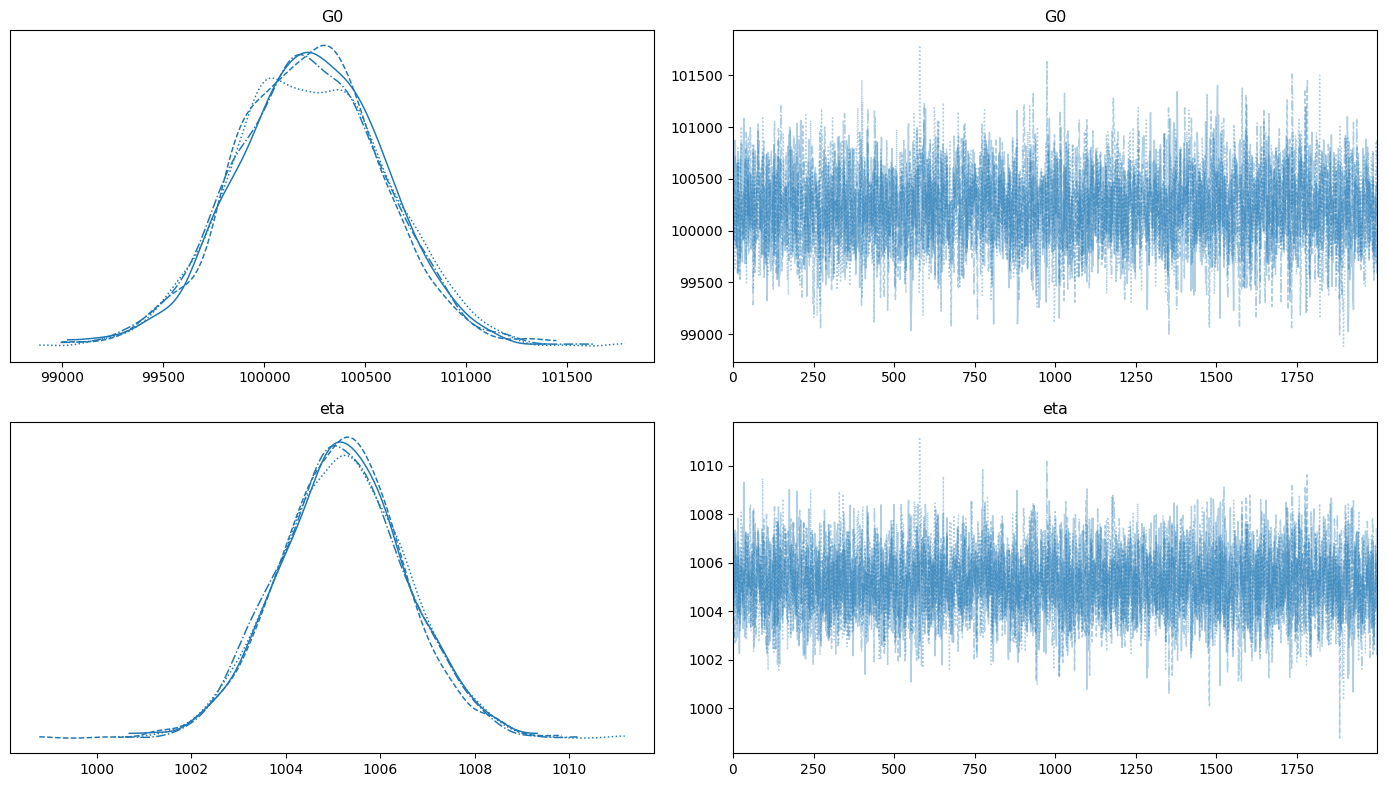


TRACE PLOT INTERPRETATION:
----------------------------------------------------------------------
LEFT PANELS (Marginal Distributions):
  ✓ GOOD: Smooth, unimodal, all chains overlap
  ✗ BAD: Bimodal, ragged, chains don't overlap

RIGHT PANELS (Parameter vs Iteration):
  ✓ GOOD: Fuzzy caterpillar, stationary, no trends
  ✗ BAD: Drift, stuck regions, discontinuities
----------------------------------------------------------------------

COMMON ISSUES:
1. Trend in trace → Not converged (increase num_warmup)
2. Stuck regions → Chain trapped (check priors, reparameterize)
3. Bimodal distribution → Multiple modes (may need more samples)
4. Chains don't overlap → Not converged (R-hat will be high)


In [5]:
# Trace plot
az.plot_trace(idata, var_names=['G0', 'eta'], figsize=(14, 8))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("\nTRACE PLOT INTERPRETATION:")
print("-" * 70)
print("LEFT PANELS (Marginal Distributions):")
print("  ✓ GOOD: Smooth, unimodal, all chains overlap")
print("  ✗ BAD: Bimodal, ragged, chains don't overlap")
print("\nRIGHT PANELS (Parameter vs Iteration):")
print("  ✓ GOOD: Fuzzy caterpillar, stationary, no trends")
print("  ✗ BAD: Drift, stuck regions, discontinuities")
print("-" * 70)
print("\nCOMMON ISSUES:")
print("1. Trend in trace → Not converged (increase num_warmup)")
print("2. Stuck regions → Chain trapped (check priors, reparameterize)")
print("3. Bimodal distribution → Multiple modes (may need more samples)")
print("4. Chains don't overlap → Not converged (R-hat will be high)")


## 6. Step 3: Rank Plot (Most Sensitive)

### Why Rank Plot?
- **Most sensitive convergence diagnostic**
- Detects subtle issues R-hat misses
- Standard for modern MCMC validation

### What It Shows
- Histogram of ranked samples across chains
- If converged, histogram should be **uniform** (flat)

### Target Pattern
- ✓ **Uniform histogram** across all bins
- ✗ **Peaks, valleys, trends** indicate non-convergence

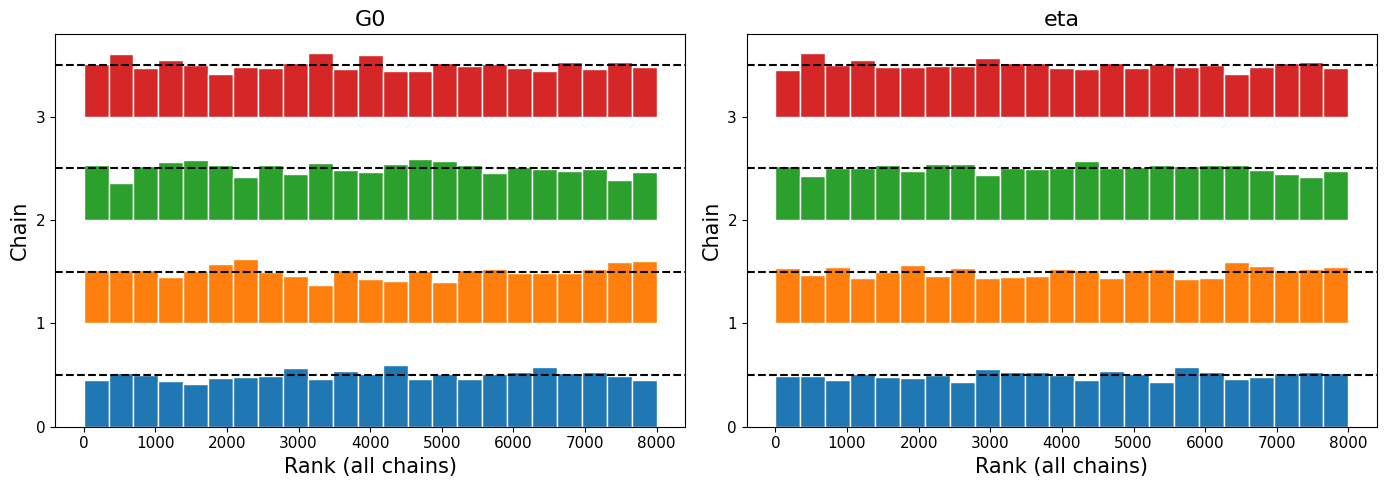


RANK PLOT INTERPRETATION:
----------------------------------------------------------------------
UNIFORM HISTOGRAM (all bins similar height):
  ✓ CONVERGED: Chains sampling from same distribution

NON-UNIFORM (peaks, valleys, trends):
  ✗ NOT CONVERGED: Chains exploring different regions
----------------------------------------------------------------------

ACTION ITEMS:
1. Non-uniform → Increase num_warmup (double: 1000 → 2000)
2. Peaks at edges → Chain sticking (check initial values, priors)
3. Consistent pattern → Systematic bias (reparameterize model)

WHY RANK PLOT OVER TRACE PLOT?
  - More sensitive to subtle non-convergence
  - Works better for high-dimensional posteriors
  - Less sensitive to posterior scale


In [6]:
# Rank plot (most sensitive)
az.plot_rank(idata, var_names=['G0', 'eta'], figsize=(14, 5))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("\nRANK PLOT INTERPRETATION:")
print("-" * 70)
print("UNIFORM HISTOGRAM (all bins similar height):")
print("  ✓ CONVERGED: Chains sampling from same distribution")
print("\nNON-UNIFORM (peaks, valleys, trends):")
print("  ✗ NOT CONVERGED: Chains exploring different regions")
print("-" * 70)
print("\nACTION ITEMS:")
print("1. Non-uniform → Increase num_warmup (double: 1000 → 2000)")
print("2. Peaks at edges → Chain sticking (check initial values, priors)")
print("3. Consistent pattern → Systematic bias (reparameterize model)")
print("\nWHY RANK PLOT OVER TRACE PLOT?")
print("  - More sensitive to subtle non-convergence")
print("  - Works better for high-dimensional posteriors")
print("  - Less sensitive to posterior scale")


## 7. Step 4: Pair Plot (Correlations & Divergences)

### What It Shows
- **Diagonal**: Marginal posteriors
- **Off-diagonal**: Joint distributions (correlations)
- **Red points**: Divergent transitions (MCMC failures)

### Correlation Patterns
- **Elliptical**: Moderate correlation (normal)
- **Diagonal line**: Strong correlation (identifiability issue)
- **Funnel**: One parameter constrains another (reparameterization needed)

### Divergences
- **< 1%**: Acceptable
- **1-5%**: Moderate (increase target_accept_prob)
- **> 5%**: Problematic (results unreliable)

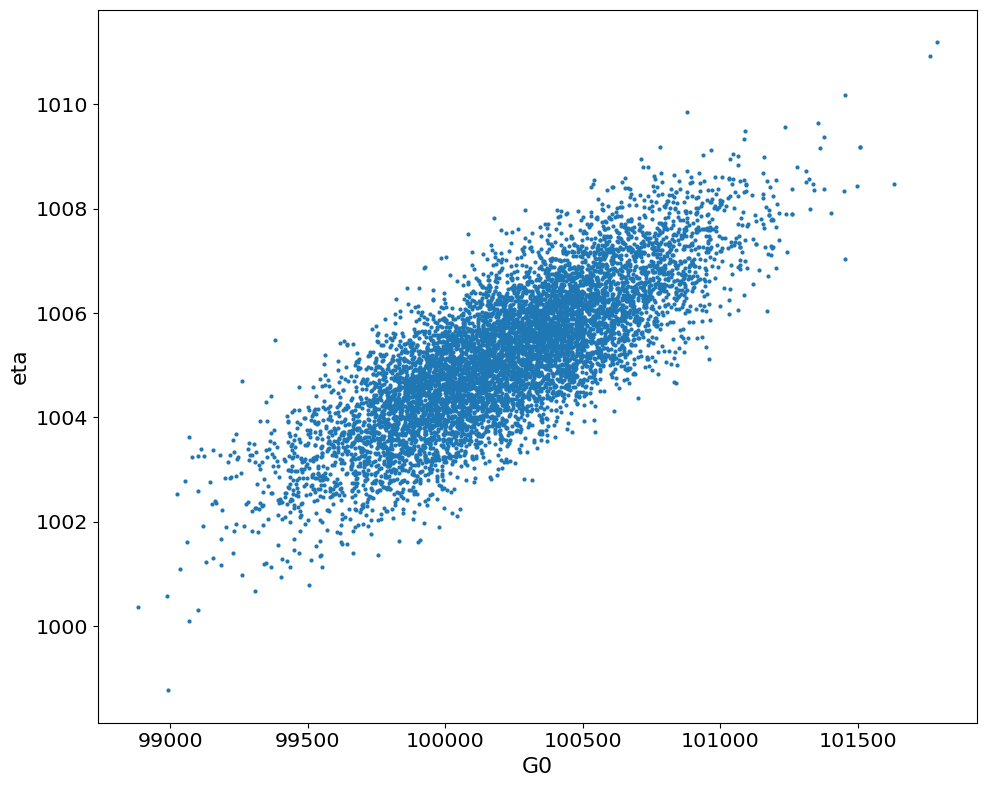


PAIR PLOT INTERPRETATION:
----------------------------------------------------------------------
Parameter Correlation: ρ(G₀, η) = 0.795

CORRELATION STRENGTH:
  |ρ| < 0.3:  Weakly correlated (well-identified) ✓
  0.3 < |ρ| < 0.7:  Moderate correlation (acceptable) ✓
  |ρ| > 0.7:  Strong correlation (identifiability issue) ✗
----------------------------------------------------------------------

DIVERGENCE TROUBLESHOOTING:
----------------------------------------------------------------------

FOR MAXWELL MODEL:
  G₀ and η correlation (0.795) is typical
  Both affect relaxation time τ = η/G₀
  This correlation is physical, not a problem


In [7]:
# Pair plot with divergences
az.plot_pair(
    idata,
    var_names=['G0', 'eta'],
    kind='scatter',
    divergences=True,
    figsize=(10, 8)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

# Compute correlation
G0_samples = result.posterior_samples['G0']
eta_samples = result.posterior_samples['eta']
correlation = np.corrcoef(G0_samples, eta_samples)[0, 1]

print("\nPAIR PLOT INTERPRETATION:")
print("-" * 70)
print(f"Parameter Correlation: ρ(G₀, η) = {correlation:.3f}\n")
print("CORRELATION STRENGTH:")
print("  |ρ| < 0.3:  Weakly correlated (well-identified) ✓")
print("  0.3 < |ρ| < 0.7:  Moderate correlation (acceptable) ✓")
print("  |ρ| > 0.7:  Strong correlation (identifiability issue) ✗")
print("-" * 70)
print("\nDIVERGENCE TROUBLESHOOTING:")
if 'num_divergences' in diagnostics:
    div_rate = diagnostics['num_divergences'] / (result.num_samples * result.num_chains) * 100
    print(f"Divergence rate: {div_rate:.2f}%")
    if div_rate < 1:
        print("  ✓ < 1%: Acceptable, model fit reliable")
    elif div_rate < 5:
        print("  ⚠ 1-5%: Moderate")
        print("    Solution: Increase target_accept_prob=0.9")
    else:
        print("  ✗ > 5%: Problematic")
        print("    Solution 1: Increase target_accept_prob=0.95")
        print("    Solution 2: Reparameterize (non-centered)")
        print("    Solution 3: Tighter priors to constrain problematic regions")
print("-" * 70)
print("\nFOR MAXWELL MODEL:")
print(f"  G₀ and η correlation ({correlation:.3f}) is typical")
print("  Both affect relaxation time τ = η/G₀")
print("  This correlation is physical, not a problem")


## 8. Step 5: Autocorrelation Plot (Mixing Quality)

### What It Shows
- Correlation between samples at different lags
- High autocorrelation → many samples needed for good ESS

### Target
- ✓ Autocorrelation drops to ~0 within 20-30 lags
- ✗ Slow decay → high autocorrelation → poor mixing

### Relation to ESS
```
ESS ≈ num_samples / (1 + 2 × Σ autocorrelations)
```
High autocorrelation → low ESS

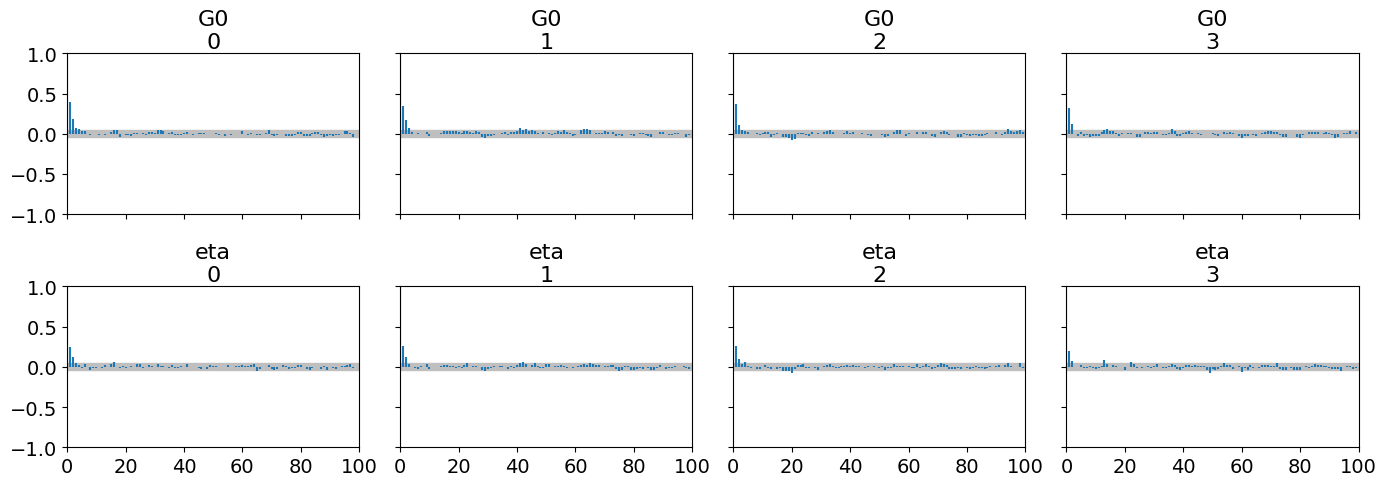


AUTOCORRELATION PLOT INTERPRETATION:
----------------------------------------------------------------------
TARGET: Autocorrelation drops to ~0 within 20-30 lags

FAST DECAY (< 30 lags):
  ✓ Good mixing, independent samples obtained quickly
  ✓ High ESS (>50% efficiency)

MODERATE DECAY (30-50 lags):
  ⚠ Acceptable mixing
  ⚠ ESS ~20-50% of num_samples
  → Consider increasing num_samples if ESS < 400

SLOW DECAY (> 50 lags):
  ✗ Poor mixing, high autocorrelation
  ✗ ESS < 20% of num_samples
  → Solution 1: Increase num_samples significantly
  → Solution 2: Check pair plot for strong correlations
  → Solution 3: Reparameterize if due to model structure
----------------------------------------------------------------------

RELATION TO ESS:
  G0: ESS = 3701 (46.3% efficiency)
       ✓ Good: Acceptable mixing
  eta: ESS = 4442 (55.5% efficiency)
       ✓ Excellent: Fast mixing


In [8]:
# Autocorrelation plot
az.plot_autocorr(
    idata,
    var_names=['G0', 'eta'],
    max_lag=100,
    figsize=(14, 5)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("\nAUTOCORRELATION PLOT INTERPRETATION:")
print("-" * 70)
print("TARGET: Autocorrelation drops to ~0 within 20-30 lags\n")
print("FAST DECAY (< 30 lags):")
print("  ✓ Good mixing, independent samples obtained quickly")
print("  ✓ High ESS (>50% efficiency)")
print("\nMODERATE DECAY (30-50 lags):")
print("  ⚠ Acceptable mixing")
print("  ⚠ ESS ~20-50% of num_samples")
print("  → Consider increasing num_samples if ESS < 400")
print("\nSLOW DECAY (> 50 lags):")
print("  ✗ Poor mixing, high autocorrelation")
print("  ✗ ESS < 20% of num_samples")
print("  → Solution 1: Increase num_samples significantly")
print("  → Solution 2: Check pair plot for strong correlations")
print("  → Solution 3: Reparameterize if due to model structure")
print("-" * 70)
print("\nRELATION TO ESS:")
for param in ['G0', 'eta']:
    ess = diagnostics['ess'][param]
    efficiency = ess / (result.num_samples * result.num_chains) * 100
    print(f"  {param}: ESS = {ess:.0f} ({efficiency:.1f}% efficiency)")
    if efficiency > 50:
        print(f"       ✓ Excellent: Fast mixing")
    elif efficiency > 20:
        print(f"       ✓ Good: Acceptable mixing")
    else:
        print(f"       ✗ Poor: High autocorrelation")


## 9. Step 6: ESS Plot (Sampling Efficiency)

### What It Shows
- Effective sample size per parameter
- Quantifies sampling efficiency

### ESS Types
- **Bulk ESS**: Central posterior (mean, median)
- **Tail ESS**: Extreme quantiles (credible interval ends)
- **Local ESS**: ESS at different quantiles (full curve)

### Targets
- Bulk ESS > 400: Reliable mean/median estimates
- Tail ESS > 400: Reliable credible intervals
- If tail ESS < bulk ESS: Need more samples for tails

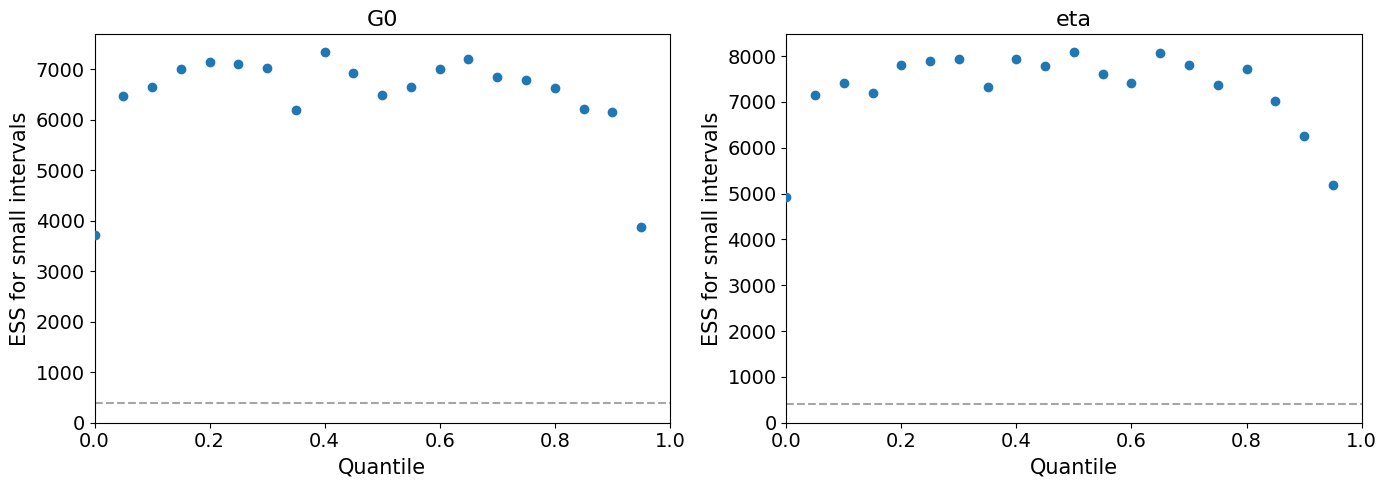


ESS PLOT INTERPRETATION:
----------------------------------------------------------------------
ESS measures effective independent samples (accounts for autocorrelation)

TARGETS:
  Bulk ESS > 400:  Reliable mean/median ✓
  Tail ESS > 400:  Reliable credible intervals ✓
----------------------------------------------------------------------

ACTION ITEMS:
ESS < 100:    Critical - Increase samples 10x
ESS 100-400:  Increase samples 2-3x
ESS > 400:    ✓ Sufficient
Tail << Bulk: Increase samples for CI reliability
----------------------------------------------------------------------

EFFICIENCY CALCULATION:
Total samples: 8000
  G0: ESS = 3701, Efficiency = 46.3%
       ✓ Good efficiency
  eta: ESS = 4442, Efficiency = 55.5%
       ✓ Excellent sampling efficiency


In [9]:
# ESS plot (local)
az.plot_ess(
    idata,
    var_names=['G0', 'eta'],
    kind='local',
    figsize=(14, 5)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("\nESS PLOT INTERPRETATION:")
print("-" * 70)
print("ESS measures effective independent samples (accounts for autocorrelation)\n")
print("TARGETS:")
print("  Bulk ESS > 400:  Reliable mean/median ✓")
print("  Tail ESS > 400:  Reliable credible intervals ✓")
print("-" * 70)
print("\nACTION ITEMS:")
print("ESS < 100:    Critical - Increase samples 10x")
print("ESS 100-400:  Increase samples 2-3x")
print("ESS > 400:    ✓ Sufficient")
print("Tail << Bulk: Increase samples for CI reliability")
print("-" * 70)
print("\nEFFICIENCY CALCULATION:")
total_samples = result.num_samples * result.num_chains
print(f"Total samples: {total_samples}")
for param in ['G0', 'eta']:
    ess = diagnostics['ess'][param]
    efficiency = ess / total_samples * 100
    print(f"  {param}: ESS = {ess:.0f}, Efficiency = {efficiency:.1f}%")
    if efficiency > 50:
        print(f"       ✓ Excellent sampling efficiency")
    elif efficiency > 20:
        print(f"       ✓ Good efficiency")
    elif efficiency > 10:
        print(f"       ⚠ Acceptable but could be better")
    else:
        print(f"       ✗ Poor efficiency (need more samples or reparameterization)")


## 10. Step 7: Energy Plot (Posterior Geometry)

### What It Shows
- NUTS energy diagnostic
- **Marginal energy**: Expected under model
- **Conditional energy**: Actual from MCMC

### Requirements
- **Multi-chain MCMC** (num_chains ≥ 2)
- Single chain: plot will fail

### Target
- ✓ **Good overlap** between distributions
- ✗ **Mismatch** → posterior geometry issues

### Causes of Mismatch
- Funnel-shaped posteriors
- Heavy tails
- Complex correlations

In [10]:
# Energy plot (requires multi-chain)
try:
    az.plot_energy(idata)
    plt.tight_layout()
    fig = plt.gcf()  # Get current figure from ArviZ
    display(fig)
    plt.close(fig)
    
    print("\nENERGY PLOT INTERPRETATION:")
    print("-" * 70)
    print("GOOD FIT (distributions overlap well):")
    print("  ✓ Posterior geometry is well-behaved")
    print("  ✓ NUTS sampling efficient")
    print("\nPOOR FIT (distributions don't match):")
    print("  ✗ Posterior geometry problematic")
    print("  → Possible causes:")
    print("    - Funnel-shaped posterior")
    print("    - Heavy tails")
    print("    - Complex parameter correlations")
    print("-" * 70)
    print("\nACTION ITEMS:")
    print("1. Mismatch detected → Reparameterize model")
    print("   (Use non-centered parameterization for hierarchical models)")
    print("2. Persistent issues → Tighter priors to regularize")
    print("3. Use with pair plot to identify problematic parameters")
except Exception as e:
    print("\nENERGY PLOT FAILED:")
    print(f"Error: {e}")
    print("\nLikely cause: Single chain MCMC (energy plot requires ≥2 chains)")
    print("Use num_chains=4 when running fit_bayesian()")



ENERGY PLOT FAILED:
Error: 'Dataset' object has no attribute 'energy'

Likely cause: Single chain MCMC (energy plot requires ≥2 chains)
Use num_chains=4 when running fit_bayesian()


## 11. Systematic Troubleshooting Guide

Follow this decision tree when diagnosing convergence issues:

In [11]:
# Automated troubleshooting function

def diagnose_convergence(result, show_solutions=True):
    """
    Automated convergence diagnostic with actionable recommendations.
    """
    diagnostics = result.diagnostics
    issues = []
    solutions = []
    
    print("\n" + "="*70)
    print("AUTOMATED TROUBLESHOOTING REPORT")
    print("="*70)
    
    # Check R-hat
    max_rhat = max(diagnostics['r_hat'].values())
    if max_rhat > 1.01:
        issues.append(f"R-hat > 1.01 (max: {max_rhat:.4f})")
        solutions.append("1. Increase num_warmup (current → 2× current)")
        solutions.append("2. Check trace plot: Are chains exploring same region?")
        solutions.append("3. Check rank plot: Is histogram uniform?")
    
    # Check ESS
    min_ess = min(diagnostics['ess'].values())
    if min_ess < 400:
        issues.append(f"ESS < 400 (min: {min_ess:.0f})")
        solutions.append("1. Increase num_samples (2000 → 5000)")
        solutions.append("2. Check autocorrelation plot: Is mixing slow?")
        solutions.append("3. Check pair plot: Are parameters correlated?")
    
    # Check divergences
    if 'num_divergences' in diagnostics:
        div_rate = diagnostics['num_divergences'] / (result.num_samples * result.num_chains)
        if div_rate > 0.05:
            issues.append(f"High divergence rate ({div_rate*100:.1f}%)")
            solutions.append("1. Increase target_accept_prob (0.8 → 0.9 or 0.95)")
            solutions.append("2. Check pair plot: Where do divergences occur?")
            solutions.append("3. Use tighter priors or reparameterize")
    
    # Report
    if not issues:
        print("\n✓✓✓ NO ISSUES DETECTED ✓✓✓")
        print("All convergence criteria met.")
        print(f"  - R-hat: {max_rhat:.4f} < 1.01")
        print(f"  - ESS: {min_ess:.0f} > 400")
        if 'num_divergences' in diagnostics:
            print(f"  - Divergences: {diagnostics['num_divergences']} ({div_rate*100:.2f}%)")
    else:
        print("\n⚠⚠⚠ ISSUES DETECTED ⚠⚠⚠\n")
        for issue in issues:
            print(f"  - {issue}")
        
        if show_solutions:
            print("\nRECOMMENDED ACTIONS:\n")
            for solution in solutions:
                print(f"  {solution}")
    
    print("="*70)
    return len(issues) == 0

# Run diagnosis
converged = diagnose_convergence(result)


AUTOMATED TROUBLESHOOTING REPORT

✓✓✓ NO ISSUES DETECTED ✓✓✓
All convergence criteria met.
  - R-hat: 1.0006 < 1.01
  - ESS: 3701 > 400


## 12. Common Failure Modes Reference

| Symptom | Likely Cause | Primary Diagnostic | Solution | Residual Pattern |
|---------|--------------|-------------------|----------|------------------|
| R-hat > 1.01 | Not converged | Rank plot | Increase `num_warmup` | Systematic bias |
| ESS < 400 | High autocorrelation | Autocorr plot | Increase `num_samples` | Consistent |
| Many divergences | Bad geometry | Pair plot | Increase `target_accept_prob` | Outliers in problematic regions |
| Bimodal posterior | Multiple modes | Trace plot | Longer chains | Residuals alternate sign |
| Strong correlations | Identifiability | Pair plot | More data or tighter priors | No clear pattern |
| Energy mismatch | Funnel geometry | Energy plot | Non-centered parameterization | Heteroscedasticity |
| Slow autocorr decay | Poor mixing | Autocorr + Pair | Reparameterize | Consistent structure |
| Non-uniform rank | Non-convergence | Rank plot | Increase warmup (most sensitive) | Depends on cause |

### Residual Analysis for Convergence Issues

**Examining residuals** (observed - predicted) helps diagnose model and MCMC problems:
- **Random scatter**: Model captures structure, MCMC working
- **Trends**: Model misspecification (underfit/overfit)
- **Heteroscedasticity** (fan pattern): Non-constant variance, consider weighted fitting
- **Outliers clustered**: May cause divergences in those regions

## Further Reading

- **ArviZ Diagnostic Gallery**: [Examples](https://python.arviz.org/en/stable/examples/index.html) — Visual guide to all diagnostic plots
- **Betancourt (2016)**: ["Diagnosing Biased Inference with Divergences"](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html) — Understanding divergences
- **Vehtari et al. (2021)**: ["Rank-normalization R-hat"](https://doi.org/10.1214/20-BA1221) — Most sensitive convergence diagnostic
- **NumPyro MCMC Guide**: [Diagnostics](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html#diagnosing-mcmc) — Implementation-specific tips

## Next Steps

- **[04-model-comparison.ipynb](04-model-comparison.ipynb)**: Compare competing models using WAIC and LOO
- **[05-uncertainty-propagation.ipynb](05-uncertainty-propagation.ipynb)**: Propagate posterior uncertainty to predictions
- Apply diagnostic workflow to your own MCMC runs systematically

- **[../transforms/01-fft-analysis.ipynb](../transforms/01-fft-analysis.ipynb)**: Frequency-domain analysis
- **[../advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Multi-protocol fitting

### Key References

- **Vehtari, A. et al. (2021).** "Rank-normalization, folding, and localization: An improved R-hat for assessing convergence of MCMC." *Bayesian Analysis* 16:667-718. [Modern convergence diagnostics]
- **Betancourt, M. (2017).** "A Conceptual Introduction to Hamiltonian Monte Carlo." arXiv:1701.02434. [Understanding NUTS sampler and divergences]
- **Gabry, J. et al. (2019).** "Visualization in Bayesian workflow." *J. Royal Stat. Soc. A* 182:389-402. [Comprehensive diagnostic workflow]

---

## Session Information

In [12]:
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"RheoJAX: {rheojax.__version__}")
print(f"JAX: {jax.__version__}")
print(f"NumPy: {np.__version__}")
print(f"ArviZ: {az.__version__}")
print(f"JAX devices: {jax.devices()}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
RheoJAX: 0.6.0
JAX: 0.8.3
NumPy: 2.3.5
ArviZ: 0.23.4
JAX devices: [CpuDevice(id=0)]
